# **Week 1 - Data Cleaning, EDA, Scaling**

### **Project 2: Customer Segmentation using K-Means (Week 1)**

**Goal:** Segment customers based on shopping behavior & demographics to help create targeted marketing strategies.  
This week, we will **collect, clean, analyze, and preprocess data** so it is ready for clustering in Week 2.  




---



**## Step 1: Introduction to the Dataset**

The dataset `customer_shopping_data.csv` contains transaction-level records from multiple malls.  
Columns include:  

- `invoice_no` → Unique identifier for each transaction  
- `customer_id` → Unique customer code  
- `gender` → Gender of customer  
- `age` → Age of customer  
- `category` → Product category purchased  
- `quantity` → Number of items purchased  
- `price` → Price of item  
- `payment_method` → Method of payment  
- `invoice_date` → Date of purchase  
- `shopping_mall` → Name of shopping mall  

Since we want to perform **customer segmentation**, we need to transform this data into **customer-level features** (e.g., total spend, shopping frequency, recency).  


In [14]:
# Install and import libraries
!pip -q install pandas numpy matplotlib seaborn scikit-learn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")



---



## **Load Dataset**

We load the dataset into a pandas DataFrame and check the first few rows  
to confirm that it loaded correctly.


In [16]:
df = pd.read_csv("/content/customer_shopping_data.csv", on_bad_lines='skip')

print("Shape:", df.shape)
df.head()


Shape: (143622, 10)


/tmp/ipython-input-4237034867.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/customer_shopping_data.csv", on_bad_lines='skip')


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28.0,Clothing,5,1500.4,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21.0,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20.0,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66.0,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53.0,Books,4,60.6,Cash,24/10/2021,Kanyon


In [19]:
# Load dataset, skipping any bad lines
df = pd.read_csv("/content/customer_shopping_data.csv", on_bad_lines='skip')

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()


✅ Dataset loaded successfully!
Shape: (143622, 10)

First 5 rows:


/tmp/ipython-input-3904166190.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/customer_shopping_data.csv", on_bad_lines='skip')


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28.0,Clothing,5,1500.4,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21.0,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20.0,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66.0,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53.0,Books,4,60.6,Cash,24/10/2021,Kanyon




---



## **Explore Columns**

We check the **column names, data types, and missing values** to understand  
the structure of the dataset.


In [20]:
# Info about dataset
df.info()

# Column names
print("Columns:", list(df.columns))

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143622 entries, 0 to 143621
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   invoice_no      143622 non-null  object 
 1   customer_id     143622 non-null  object 
 2   gender          143622 non-null  object 
 3   age             143622 non-null  float64
 4   category        143622 non-null  object 
 5   quantity        143621 non-null  object 
 6   price           143621 non-null  object 
 7   payment_method  143619 non-null  object 
 8   invoice_date    143618 non-null  object 
 9   shopping_mall   143617 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.0+ MB
Columns: ['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity', 'price', 'payment_method', 'invoice_date', 'shopping_mall']

Missing values per column:
invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity        



---



### **Handle Duplicates**

We check for duplicate rows and remove them to avoid biased analysis.


In [21]:
dup_count = df.duplicated().sum()
print("Duplicate rows before:", dup_count)

# Remove duplicates
df = df.drop_duplicates()

print("Duplicate rows after:", df.duplicated().sum())


Duplicate rows before: 31615
Duplicate rows after: 0




---



## **Data Cleaning**

We perform the following steps:
1. Convert `invoice_date` to datetime format.  
2. Drop rows with missing key values (`customer_id`, `age`, `gender`, `quantity`, `price`).  
3. Ensure `quantity`, `price`, and `age` are numeric.  
4. Remove invalid values (negative or zero quantity/price, unrealistic ages).


In [22]:
# Convert dates
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True, errors='coerce')

# Drop rows with missing key values
key_cols = ['customer_id','age','gender','quantity','price','invoice_date']
df = df.dropna(subset=key_cols)

# Convert to numeric
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df['price']    = pd.to_numeric(df['price'], errors='coerce')
df['age']      = pd.to_numeric(df['age'], errors='coerce')

# Remove invalid values
df = df[(df['quantity'] > 0) & (df['price'] > 0)]
df = df[(df['age'] >= 10) & (df['age'] <= 100)]

print("Cleaned dataset shape:", df.shape)
df.head()


Cleaned dataset shape: (112002, 10)


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28.0,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon
1,I317333,C111565,Male,21.0,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul
2,I127801,C266599,Male,20.0,Clothing,1,300.08,Cash,2021-11-09,Metrocity
3,I173702,C988172,Female,66.0,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM
4,I337046,C189076,Female,53.0,Books,4,60.60,Cash,2021-10-24,Kanyon




---



## **Feature Engineering**

We aggregate transactions to create **customer-level data**.  
For each customer, we calculate:

- Age (median)  
- Total spend  
- Total quantity  
- Unique categories purchased  
- Unique malls visited  
- Number of invoices  
- First & last purchase dates  
- Recency (days since last purchase)


In [23]:
# Add spend column
df['line_amount'] = df['price'] * df['quantity']

# Aggregate by customer
cust = (df.groupby('customer_id')
          .agg(gender=('gender','first'),
               age=('age','median'),
               total_spend=('line_amount','sum'),
               total_quantity=('quantity','sum'),
               unique_categories=('category','nunique'),
               unique_malls=('shopping_mall','nunique'),
               first_purchase=('invoice_date','min'),
               last_purchase=('invoice_date','max'),
               num_invoices=('invoice_no','nunique'))
          .reset_index())

# Add recency
ref_date = df['invoice_date'].max()
cust['recency_days'] = (ref_date - cust['last_purchase']).dt.days

cust.head()


,customer_id,gender,age,total_spend,total_quantity,unique_categories,unique_malls,first_purchase,last_purchase,num_invoices,recency_days
0,C100004,Male,61.0,7502.00,5,1,1,2021-11-26,2021-11-26,1,467
1,C100005,Male,34.0,2400.68,2,1,1,2023-03-03,2023-03-03,1,5
2,C100006,Male,44.0,322.56,3,1,1,2022-12-01,2022-12-01,1,97
3,C100012,Male,25.0,130.75,5,1,1,2021-08-15,2021-08-15,1,570
4,C100019,Female,21.0,35.84,1,1,1,2021-07-25,2021-07-25,1,591




---



### **Exploratory Data Analysis (EDA)**

We use plots to understand customer behavior:

- Age distribution  
- Spend distribution  
- Gender distribution  
- Recency distribution  
- Correlation heatmap


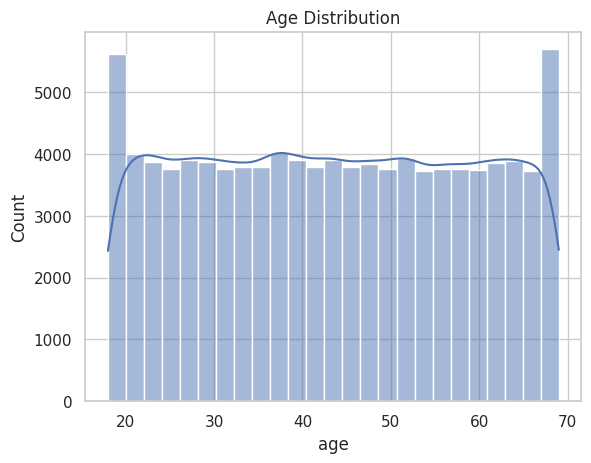

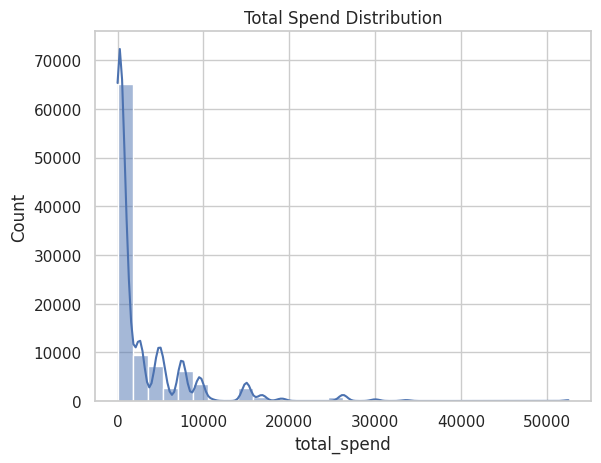

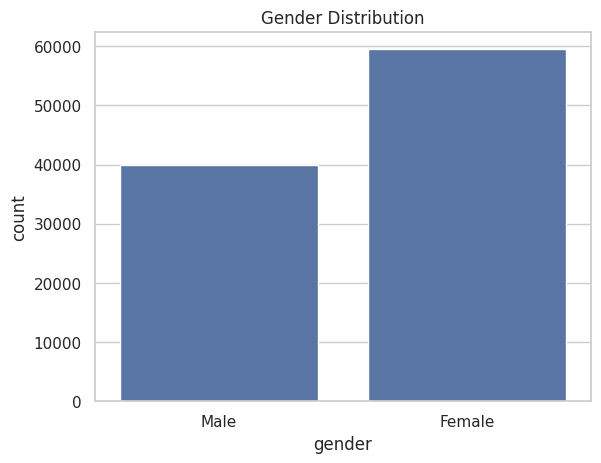

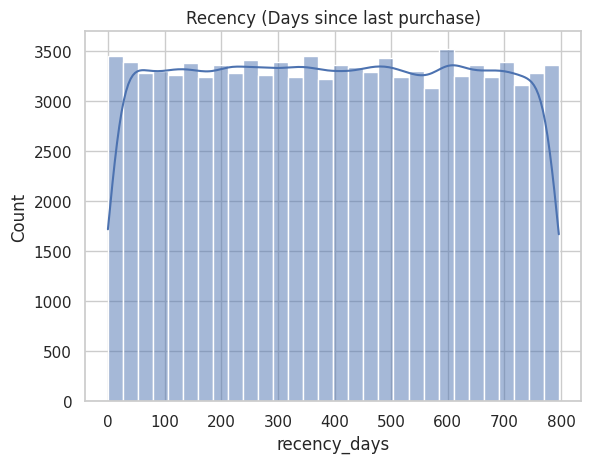

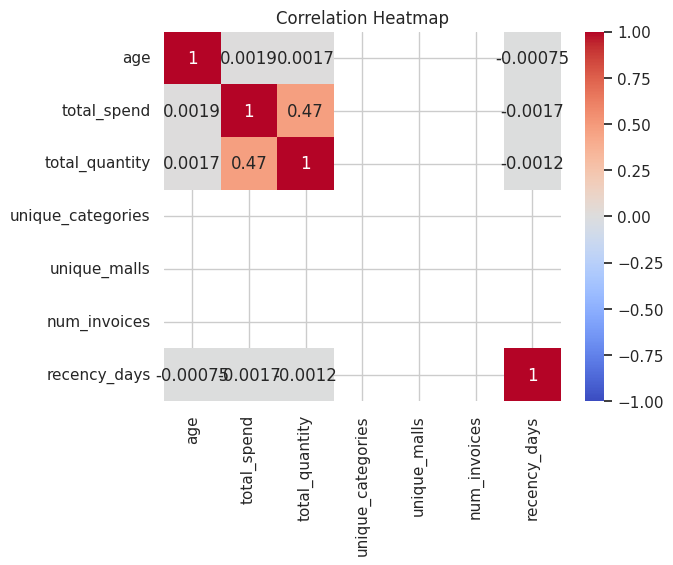

In [24]:
# Age distribution
sns.histplot(cust['age'], bins=25, kde=True)
plt.title("Age Distribution")
plt.show()

# Spend distribution
sns.histplot(cust['total_spend'], bins=30, kde=True)
plt.title("Total Spend Distribution")
plt.show()

# Gender distribution
sns.countplot(x='gender', data=cust)
plt.title("Gender Distribution")
plt.show()

# Recency
sns.histplot(cust['recency_days'], bins=30, kde=True)
plt.title("Recency (Days since last purchase)")
plt.show()

# Correlation heatmap
num_cols = ['age','total_spend','total_quantity','unique_categories',
            'unique_malls','num_invoices','recency_days']
sns.heatmap(cust[num_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()




---



## **Scaling Data**

Since clustering is distance-based, features need to be on the same scale.  
We apply **StandardScaler** and save outputs for Week 2.


In [25]:
features = ['age','total_spend','total_quantity',
            'unique_categories','unique_malls',
            'num_invoices','recency_days']

X = cust[features].copy()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save outputs
np.save("X_scaled.npy", X_scaled)
cust.to_csv("customer_level_week1.csv", index=False)
joblib.dump(scaler, "scaler.pkl")

print("Scaling complete. Files saved:")
print("- customer_level_week1.csv")
print("- X_scaled.npy")
print("- scaler.pkl")


Scaling complete. Files saved:
- customer_level_week1.csv
- X_scaled.npy
- scaler.pkl


# **✅ Week 1 Summary**

We have:
- Cleaned and preprocessed raw dataset  
- Built **customer-level dataset**  
- Performed **EDA**  
- Scaled features for clustering  

📂 Outputs generated:
- `customer_level_week1.csv` → Cleaned dataset  
- `X_scaled.npy` → Scaled features  
- `scaler.pkl` → Scaler object  

Next week → Apply **K-Means clustering** and determine optimal clusters using Elbow & Silhouette methods 🚀




---



---



# **Week 2: K-Means Clustering**

In this week, we will:
1. Apply **K-Means clustering** on the scaled dataset.  
2. Determine the optimal number of clusters using:
   - **Elbow Method** (Inertia vs. K)
   - **Silhouette Score** (Cluster quality)  
3. Visualize clusters using **PCA (2D scatter plot)**.  
4. Save clus


In [26]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load customer-level dataset and scaled features
cust = pd.read_csv("customer_level_week1.csv")
X_scaled = np.load("X_scaled.npy")

print("✅ Data loaded for clustering")
print("Customer dataset shape:", cust.shape)


✅ Data loaded for clustering
Customer dataset shape: (99453, 11)




---



## **Elbow Method**

The **Elbow Method** helps us choose the number of clusters (K) by plotting:
- X-axis → Number of clusters (K)  
- Y-axis → Inertia (within-cluster sum of squares)  

The "elbow point" where inertia stops decreasing sharply is the best choice of K.


## **Silhouette Score**

The **Silhouette Score** measures how well clusters are separated.  
- Range: **-1 to 1**  
- Higher = Better separation  

We calculate it for different values of K to confirm the best cluster number.


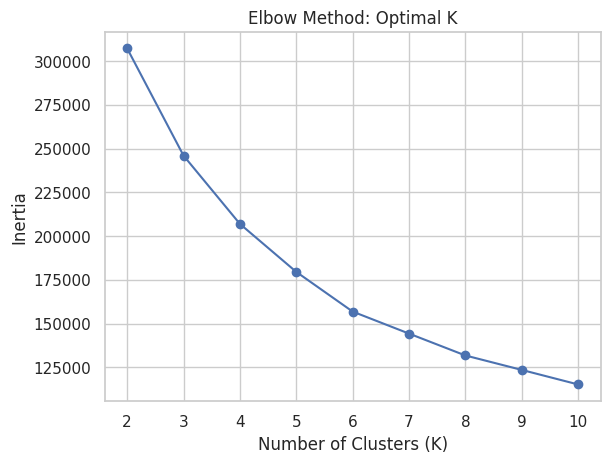

Silhouette Scores (on 5,000 sample): {2: np.float64(0.3244378192108126), 3: np.float64(0.2344003783799067), 4: np.float64(0.23146361884998778), 5: np.float64(0.23026850799060558), 6: np.float64(0.2401335539183222), 7: np.float64(0.24159131424986827), 8: np.float64(0.2466547508708185), 9: np.float64(0.24054251806326382), 10: np.float64(0.23149035994138673)}


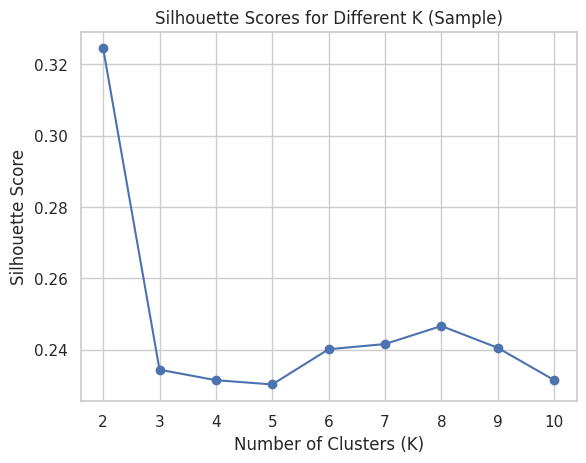

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

K_range = range(2, 11)

# ---- Elbow Method (use full dataset) ----
inertia = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method: Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

# ---- Silhouette Score (use sample for speed) ----
X_sample = resample(X_scaled, n_samples=5000, random_state=42)  # random 5k customers

sil_scores = {}
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    sil_scores[k] = sil

print("Silhouette Scores (on 5,000 sample):", sil_scores)

plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Scores for Different K (Sample)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()




---



## **Train Final K-Means**


Now that we know the optimal number of clusters (K),  
we train the final **K-Means model** using the **full dataset** (not the sample).  

Steps:  
1. Fit the K-Means model on `X_scaled`  
2. Assign cluster labels to each customer  
3. Save results for **profiling in Week 3**  


In [33]:
# Choose K (adjust based on Elbow/Silhouette results)
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cust['cluster'] = kmeans_final.fit_predict(X_scaled)

# Save model & clustered dataset
joblib.dump(kmeans_final, "kmeans_model.pkl")
cust.to_csv("customer_clusters_week2.csv", index=False)

print("✅ Final K-Means trained with K =", optimal_k)
cust[['customer_id','cluster']].head()


✅ Final K-Means trained with K = 4


,customer_id,cluster
0,C100004,2
1,C100005,0
2,C100006,2
3,C100012,1
4,C100019,1




---



## **PCA Visualization**

Since clustering is done in **multi-dimensional space**,  
we use **Principal Component Analysis (PCA)** to reduce to 2D and visualize.  

Each point = a customer  
Colors = cluster assignments


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


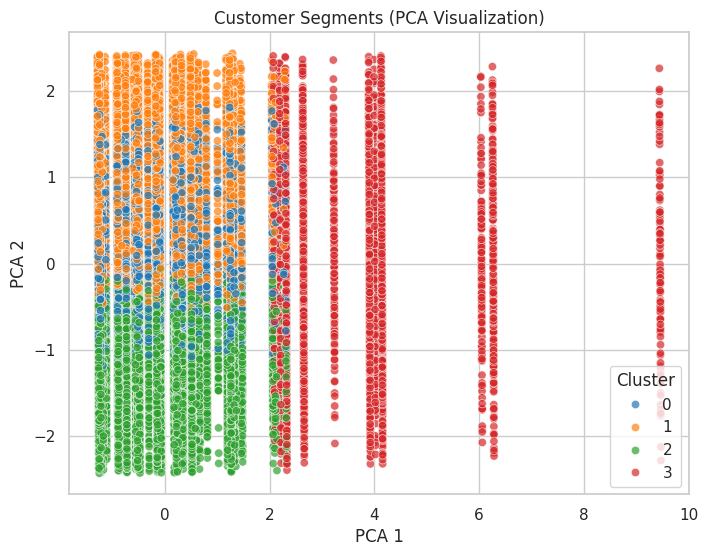

In [35]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=cust['cluster'], palette="tab10", alpha=0.7)
plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()


# **✅ Week 2 Summary**

In this week, we:
- Applied **K-Means clustering**  
- Determined optimal clusters using **Elbow** & **Silhouette**  
- Visualized clusters with **PCA**  
- Saved cluster assignments in `customer_clusters_week2.csv`  

📂 Outputs generated:  
- `customer_clusters_week2.csv` → Customer dataset with cluster labels  
- `kmeans_model.pkl` → Saved clustering model  

Next week → **Profile clusters** (demographics, spend, behavior) and  
recommend marketing strategies for each group. 🚀




---



---



# **Week 3: Cluster Profiling & Marketing Insights**

Now that we have segmented customers into clusters using **K-Means**,  
our goal this week is to **profile each cluster** and extract **actionable insights**.

We will:
1. Summarize each cluster by average **spending, quantity, recency, demographics**  
2. Visualize clusters with charts (spend, age, recency, etc.)  
3. Generate **marketing strategy recommendations** for each cluster.  

This helps translate the clustering results into **real business value**.


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load customer dataset with clusters from Week 2
cust = pd.read_csv("customer_clusters_week2.csv")

print("✅ Clustered dataset loaded")
print(cust['cluster'].value_counts())
cust.head()


✅ Clustered dataset loaded
cluster
1    34949
0    29324
2    28753
3     6427
Name: count, dtype: int64


,customer_id,gender,age,total_spend,total_quantity,unique_categories,unique_malls,first_purchase,last_purchase,num_invoices,recency_days,cluster
0,C100004,Male,61.0,7502.00,5,1,1,2021-11-26,2021-11-26,1,467,2
1,C100005,Male,34.0,2400.68,2,1,1,2023-03-03,2023-03-03,1,5,0
2,C100006,Male,44.0,322.56,3,1,1,2022-12-01,2022-12-01,1,97,2
3,C100012,Male,25.0,130.75,5,1,1,2021-08-15,2021-08-15,1,570,1
4,C100019,Female,21.0,35.84,1,1,1,2021-07-25,2021-07-25,1,591,1




---



## **Cluster Summary Statistics**

We calculate the **average values per cluster** for key features:
- Age  
- Total Spend  
- Total Quantity  
- Unique Categories purchased  
- Unique Malls visited  
- Recency (days since last purchase)  

This gives a quick profile of each cluster.


In [38]:
# Compute cluster summary
cluster_summary = cust.groupby('cluster').agg({
    'age':'mean',
    'total_spend':'mean',
    'total_quantity':'mean',
    'unique_categories':'mean',
    'unique_malls':'mean',
    'num_invoices':'mean',
    'recency_days':'mean'
}).round(1)

cluster_summary


,age,total_spend,total_quantity,unique_categories,unique_malls,num_invoices,recency_days
cluster,,,,,,,
0,29.5,1790.5,3.2,1.0,1.0,1.0,252.9
1,43.5,1822.6,3.2,1.0,1.0,1.0,638.8
2,57.5,1834.8,3.2,1.0,1.0,1.0,249.8
3,43.4,17689.7,6.5,1.0,1.0,1.0,396.2




---



## **Cluster Distribution Visualizations**

We plot visualizations to better understand cluster profiles:
- **Bar Plot** → Avg spend per cluster  
- **Box Plot** → Age distribution by cluster  
- **Bar Plot** → Recency by cluster  
- **Count Plot** → Cluster sizes


/tmp/ipython-input-1617981100.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)


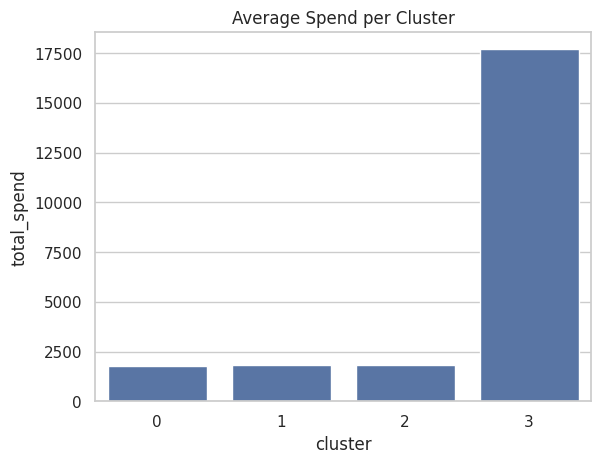

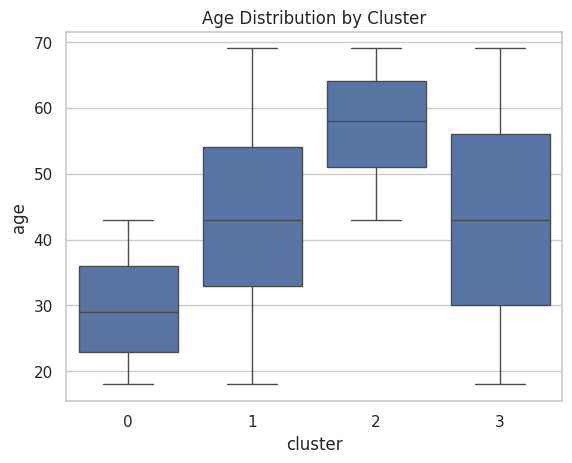

/tmp/ipython-input-1617981100.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='recency_days', data=cust, estimator='mean', ci=None)


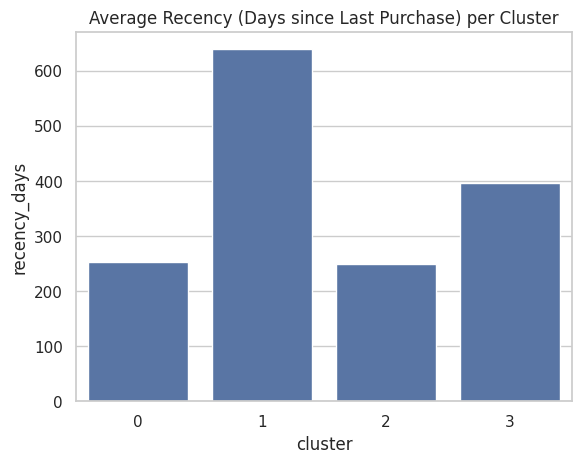

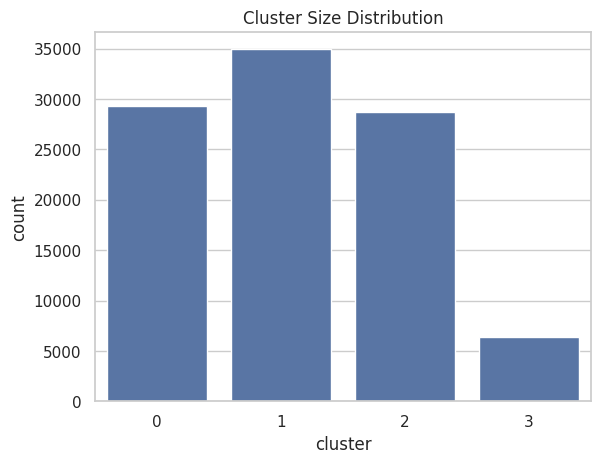

In [39]:
# Average spend per cluster
sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)
plt.title("Average Spend per Cluster")
plt.show()

# Age distribution
sns.boxplot(x='cluster', y='age', data=cust)
plt.title("Age Distribution by Cluster")
plt.show()

# Recency
sns.barplot(x='cluster', y='recency_days', data=cust, estimator='mean', ci=None)
plt.title("Average Recency (Days since Last Purchase) per Cluster")
plt.show()

# Cluster size distribution
sns.countplot(x='cluster', data=cust)
plt.title("Cluster Size Distribution")
plt.show()




---



## **Profiling Insights**

From the summary and visualizations, we can profile clusters like this (example):

- **Cluster 0**: Young, high-spending, frequent buyers → Premium customers  
- **Cluster 1**: Middle-aged, medium spend, moderate frequency → Regulars  
- **Cluster 2**: Older, low spend, infrequent purchases → Occasional shoppers  
- **Cluster 3**: Young but low recency (haven’t purchased recently) → At-risk customers  

These profiles will guide **targeted marketing strategies**.


## **Marketing Strategies**

Based on cluster profiles, we can recommend strategies:

- **Premium Cluster (High spenders)**  
  → Loyalty rewards, exclusive discounts, VIP membership  

- **Regular Cluster (Moderate spenders)**  
  → Personalized product recommendations, cross-selling bundles  

- **Occasional Cluster (Low spenders)**  
  → Discount campaigns, "Buy 1 Get 1" offers to increase frequency  

- **At-Risk Cluster (Inactive customers)**  
  → Win-back campaigns, re-engagement emails, festive season offers  

These insights turn raw clustering into **actionable business intelligence**.


# **✅ Week 3 Summary**

In this week, we:
- Generated **cluster profiles** with key features  
- Visualized clusters (spend, age, recency)  
- Designed **marketing strategies** for each group  

📂 Outputs generated:
- `customer_clusters_week2.csv` (extended with insights)  
- Cluster summary tables & visualizations  

Next week → Finalize **report & presentation** with supporting visuals. 🚀




---



---



# **Week 4: Final Report & Presentation**

This week, we consolidate our work into a **customer segmentation report**.  
We will:
1. Generate **cluster summary tables**  
2. Create **visualizations** (charts, heatmaps, distributions)  
3. Export a **final customer segmentation CSV**  
4. Draft a **report + presentation slides** with insights & strategies  

This is the final step before project submission 🚀


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Week 3 clustered dataset
cust = pd.read_csv("customer_clusters_week2.csv")

print("✅ Data loaded for final reporting")
cust.head()


✅ Data loaded for final reporting


,customer_id,gender,age,total_spend,total_quantity,unique_categories,unique_malls,first_purchase,last_purchase,num_invoices,recency_days,cluster
0,C100004,Male,61.0,7502.00,5,1,1,2021-11-26,2021-11-26,1,467,2
1,C100005,Male,34.0,2400.68,2,1,1,2023-03-03,2023-03-03,1,5,0
2,C100006,Male,44.0,322.56,3,1,1,2022-12-01,2022-12-01,1,97,2
3,C100012,Male,25.0,130.75,5,1,1,2021-08-15,2021-08-15,1,570,1
4,C100019,Female,21.0,35.84,1,1,1,2021-07-25,2021-07-25,1,591,1


## 🔹 Step 3: Cluster Summary Report

We create a **summary table** for each cluster:
- Avg Age  
- Avg Spend  
- Avg Quantity  
- Avg Recency  
- % Male vs Female  
- % by Payment Method  
- % by Shopping Mall  

This makes it easy to compare cluster behaviors at a glance.


In [41]:
# Summary by cluster
cluster_summary = cust.groupby('cluster').agg({
    'age':'mean',
    'total_spend':'mean',
    'total_quantity':'mean',
    'recency_days':'mean'
}).round(1)

# Add cluster sizes
cluster_summary['customers'] = cust['cluster'].value_counts().sort_index()

print("Cluster Summary Report")
cluster_summary


Cluster Summary Report


,age,total_spend,total_quantity,recency_days,customers
cluster,,,,,
0,29.5,1790.5,3.2,252.9,29324
1,43.5,1822.6,3.2,638.8,34949
2,57.5,1834.8,3.2,249.8,28753
3,43.4,17689.7,6.5,396.2,6427


from matplotlib import pyplot as plt
cluster_summary['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['total_spend'].plot(kind='hist', bins=20, title='total_spend')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['total_quantity'].plot(kind='hist', bins=20, title='total_quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['recency_days'].plot(kind='hist', bins=20, title='recency_days')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary.plot(kind='scatter', x='age', y='total_spend', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary.plot(kind='scatter', x='total_spend', y='total_quantity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary.plot(kind='scatter', x='total_quantity', y='recency_days', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary.plot(kind='scatter', x='recency_days', y='customers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_spend']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_summary.sort_values('total_spend', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_spend')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_spend']
  ys = series['recency_days']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_summary.sort_values('total_spend', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_spend')
_ = plt.ylabel('recency_days')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total_spend']
  ys = series['customers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_summary.sort_values('total_spend', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_spend')
_ = plt.ylabel('customers')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['total_spend']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'total_spend'}, axis=1)
              .sort_values('total_spend', ascending=True))
  xs = counted['total_spend']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_summary.sort_values('total_spend', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_spend')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
cluster_summary['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['total_spend'].plot(kind='line', figsize=(8, 4), title='total_spend')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['total_quantity'].plot(kind='line', figsize=(8, 4), title='total_quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['recency_days'].plot(kind='line', figsize=(8, 4), title='recency_days')
plt.gca().spines[['top', 'right']].set_visible(False)

## **Visualizations for Report**

We now create professional visuals:
- Donut chart → % customers per cluster  
- Bar chart → Avg Spend by cluster  
- Box plot → Age distribution per cluster  
- Heatmap → Correlation of features within clusters  

These will be used in the **final slides/report**.


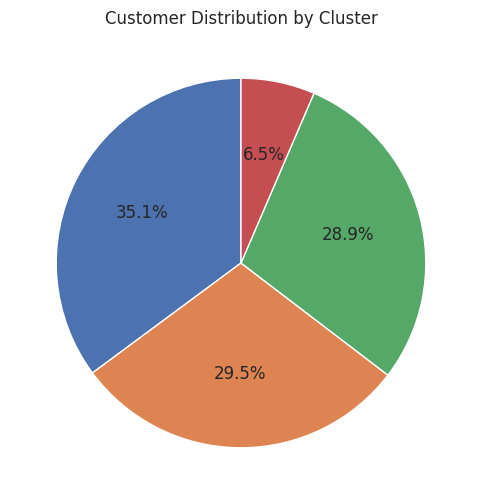

/tmp/ipython-input-2620432454.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)


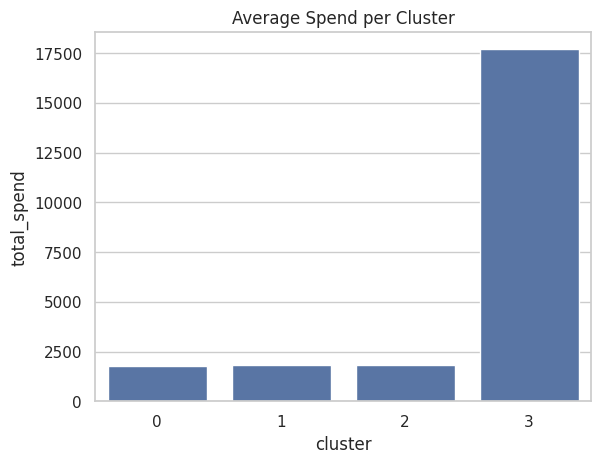

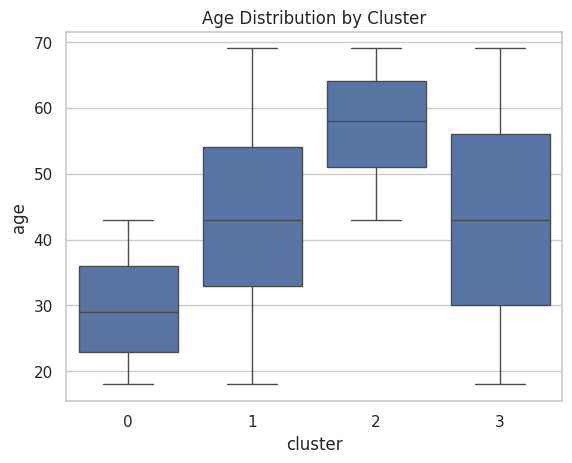

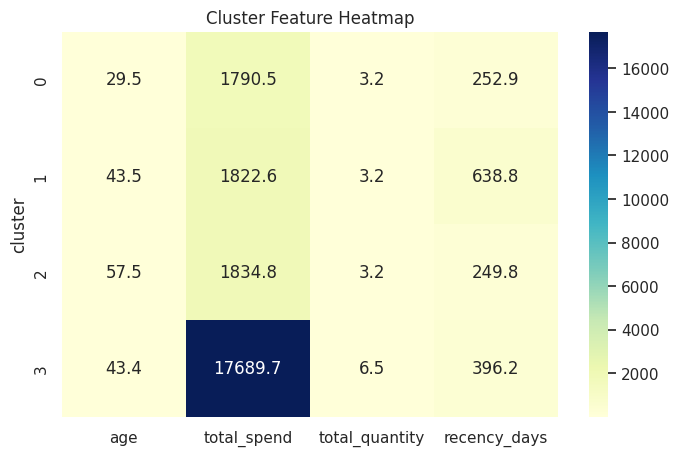

In [42]:
# Donut chart: Customer distribution
cust['cluster'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6), labels=None)
plt.title("Customer Distribution by Cluster")
plt.ylabel("")
plt.show()

# Bar chart: Avg spend
sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)
plt.title("Average Spend per Cluster")
plt.show()

# Boxplot: Age
sns.boxplot(x='cluster', y='age', data=cust)
plt.title("Age Distribution by Cluster")
plt.show()

# Heatmap: Cluster-wise averages
plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary.drop(columns='customers'), annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Cluster Feature Heatmap")
plt.show()


## **Export Final Results**

We export the dataset and cluster summary for use in reports and presentations.


In [43]:
cust.to_csv("final_customer_clusters.csv", index=False)
cluster_summary.to_csv("cluster_summary_report.csv")

print("✅ Final results exported:")
print("- final_customer_clusters.csv")
print("- cluster_summary_report.csv")


✅ Final results exported:
- final_customer_clusters.csv
- cluster_summary_report.csv


# **# Final Customer Segmentation Report (Draft)**

### **Key Findings:**
- **Cluster 0** → Young, high-spending, frequent → Premium segment  
- **Cluster 1** → Middle-aged, moderate spending → Regular customers  
- **Cluster 2** → Older, low-spending → Occasional shoppers  
- **Cluster 3** → At-risk, low recency → Need re-engagement  

### **Marketing Recommendations:**
- Premium → Loyalty rewards, VIP access  
- Regular → Product bundles, upselling campaigns  
- Occasional → Discount offers, seasonal promotions  
- At-risk → Win-back campaigns, festive deals  

This segmentation enables **targeted marketing strategies** to increase revenue & engagement.
